In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generating orientations

### A regular grid from a spherical mesh
The output is euler angles of orientations, with the first euler angle constrained to 0

In [3]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid

grid = get_beam_directions_grid("cubic",1, mesh="spherified_cube_corner")
grid_random = get_beam_directions_grid("cubic",1, mesh="random")

/Users/nielscautaerts/Documents/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:507: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


### Verifying the grids
We map the grid onto the stereographic projection

In [4]:
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
rotations_random =  Rotation.from_euler(np.deg2rad(grid_random))
rot_reg_test = rotations_regular*Vector3d.zvector()
rot_rand_test = rotations_random*Vector3d.zvector()

In [5]:
from orix.plot.stereo_plot import StereoPlot

<IPython.core.display.Javascript object>


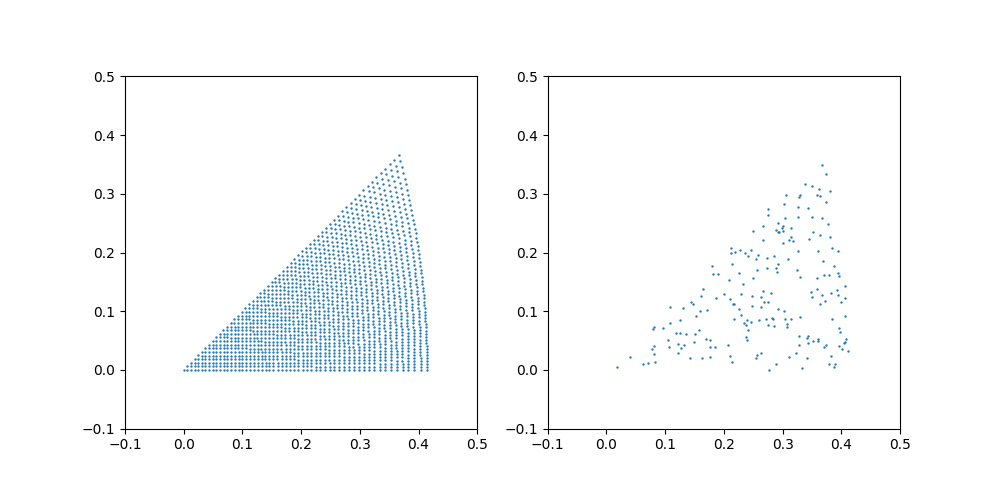

(-0.1, 0.5)

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax2 = ax.ravel()
ax1.scatter(rot_reg_test, s = 0.5)
ax2.scatter(rot_rand_test, s = 0.5)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)
ax2.set_xlim(-0.1, 0.5)
ax2.set_ylim(-0.1, 0.5)

### Releasing the constraint on the third angle
All the orientations inside this triangle will be unique for the cubic crystal system with no overlap. We can now freely choose the third euler angle on a uniform distribution to get access to all possible unique orientations of the cube. Only exactly in the coorners will there be additional symmetry: at the 001 corner 4 times rotational symmetry, at the 101 corner 2 times, at the 111 corner 3 times.

# 2. Generating a diffraction pattern simulation
* Loading a structure
* Set up the simulation
* Generate library

In [7]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

In [8]:
import diffpy
structure_aus = diffpy.structure.loadStructure("Data/austeniteLP.cif")
structure_G = diffpy.structure.loadStructure("Data/g-phaseLP.cif")

In [9]:
# diffraction generator controls how the patterns will be simulated
diff_gen = DiffractionGenerator(accelerating_voltage=200, shape_factor_model="lorentzian")

Extract relevant information from the image

In [10]:
import hyperspy.api as hs

In [11]:
experimental_data = hs.load("data/subset_data.hspy")

In [12]:
experimental_data.axes_manager

<Axes manager, axes: (2, 2|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |      2 |      0 |   2e+02 |       2 |     nm 
               y |      2 |      0 |   2e+02 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

In [23]:
# experimental values necessary to scale the simulations
half_width_image = experimental_data.axes_manager["kx"].size//2
diffraction_scale = experimental_data.axes_manager["kx"].scale
reciprocal_radius = np.sqrt(2)*half_width_image*diffraction_scale

### You can generate these with a manual loop

In [375]:
from tqdm import tqdm
simulations = []
for orientation in tqdm(grid):
    simulation = diff_gen.calculate_ed_data(
        structure_aus,
        reciprocal_radius,
        orientation,
        with_direct_beam=False,
        max_excitation_error=0.6e-1,
    )
    simulation.calibration = diffraction_scale
    simulations.append(simulation)

100%|██████████| 1596/1596 [00:20<00:00, 77.42it/s]


### The recommended way to generate the simulations is with the librarygenerator

In [15]:
# list of phase names, list of structures, list of orientation grids to simulate
library_phases = StructureLibrary(["steel", "g"], [structure_aus, structure_G], [grid, grid])
lib_gen = DiffractionLibraryGenerator(diff_gen)
diff_lib = lib_gen.get_diffraction_library(library_phases,
                                           calibration=diffraction_scale,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_width_image, half_width_image),
                                           with_direct_beam=False,
                                           max_excitation_error=0.6e-1)

NameError: name 'diffraction_scale' is not defined

In [153]:
# save the library
diff_lib.pickle_library('./Data/phase_template_library.pickle')

### Plotting the templates

In [15]:
from diffsims.libraries.diffraction_library import load_DiffractionLibrary
diff_lib = load_DiffractionLibrary('./Data/phase_template_library.pickle', safety=True)

In [16]:
test_simulation = diff_lib["steel"]["simulations"][140] #0 corresponds to 001 diffraction pattern

In [17]:
from pyxem.utils.plotting_utils import plot_template

<IPython.core.display.Javascript object>


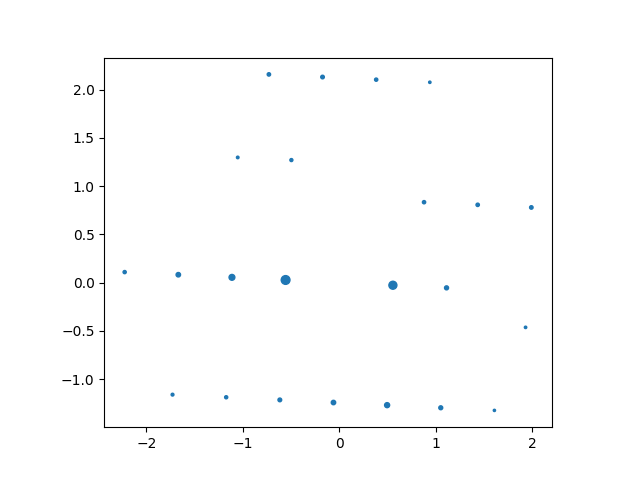

(<AxesSubplot:>, <matplotlib.collections.PathCollection at 0x146f15dc0>)

In [18]:
plot_template(test_simulation)

# 3. Matching in-plane orientation

## 3.1 Matching one pattern to one template

In [13]:
from pyxem.utils.plotting_utils import plot_template_over_pattern
from pyxem.utils.indexation_utils import get_in_plane_rotation_correlation

In [19]:
import matplotlib.pyplot as plt

image_test = experimental_data.data[0,0]
simulation_test = diff_lib["steel"]["simulations"][0]

a1, c1 = get_in_plane_rotation_correlation(image_test, simulation_test)
a2, c2 = get_in_plane_rotation_correlation(image_test, simulation_test, delta_theta=4)
a3, c3 = get_in_plane_rotation_correlation(image_test, simulation_test, delta_r=4)

fig, ax = plt.subplots()
ax.plot(a1, c1/np.amax(c1), label=r"$\Delta_r=1, \Delta_\theta=1$")
ax.plot(a2, c2/np.amax(c2), label=r"$\Delta_r=1, \Delta_\theta=4$")
ax.plot(a3, c3/np.amax(c3), label=r"$\Delta_r=4, \Delta_\theta=1$")
ax.set_xlabel(r"in-plane angle ($^\circ)")
ax.set_ylabel("Correlation index")
ax.legend()

<IPython.core.display.Javascript object>

Best fit angle: 38


<IPython.core.display.Javascript object>


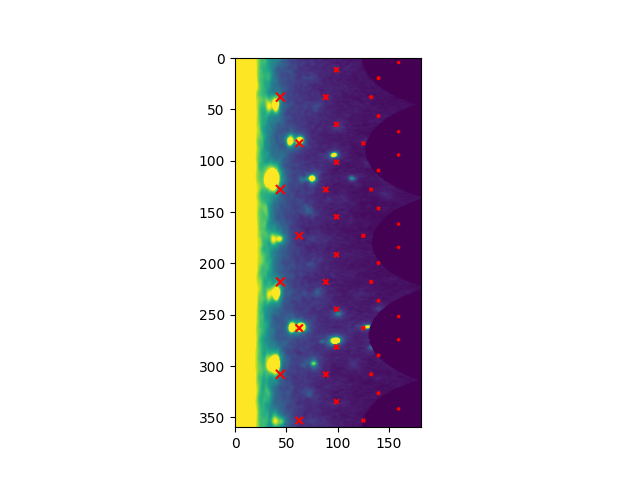

<IPython.core.display.Javascript object>


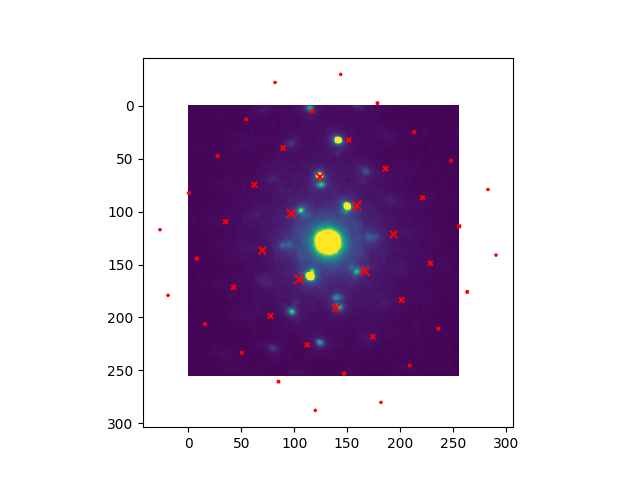

(<AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x14961a370>)

In [20]:
in_plane_angle = np.argmax(c1)
print("Best fit angle:", in_plane_angle)
plot_template_over_pattern(image_test, simulation_test, in_plane_angle=in_plane_angle,
                                coordinate_system = "polar", vmax=0.01)
plot_template_over_pattern(image_test, simulation_test, in_plane_angle=in_plane_angle,
                                coordinate_system = "cartesian", vmax=2000)

## 3.2 Matching a pattern to the entire template library

In [22]:
from pyxem.utils.indexation_utils import (correlate_library_to_pattern,
                                         correlate_library_to_pattern_fast)

In [23]:
simulations = diff_lib["steel"]["simulations"]
angles, corrs, corrs_inv = correlate_library_to_pattern(image_test, simulations)

In [24]:
corrs_fast = correlate_library_to_pattern_fast(image_test, simulations)

In [43]:
best_fit_index = np.argmax(corrs)

<IPython.core.display.Javascript object>


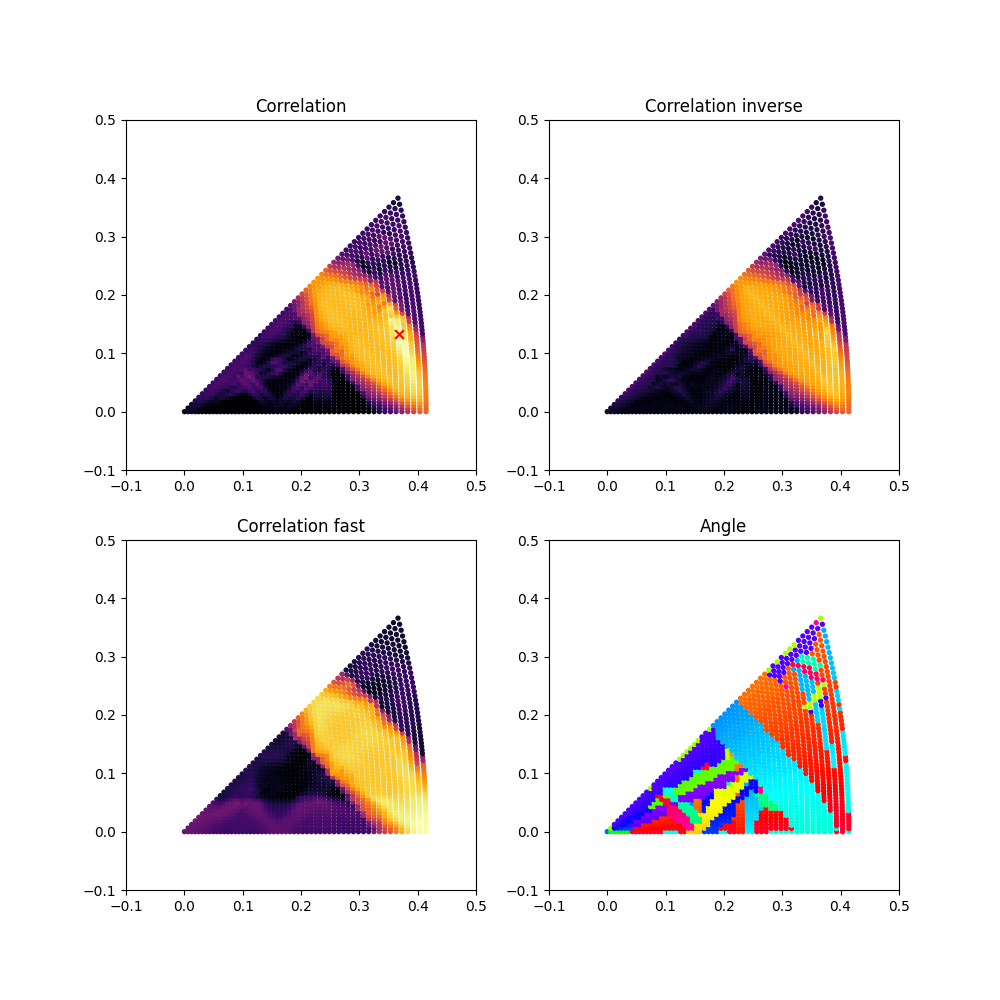

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={"projection": "stereographic"})
ax1, ax2, ax3, ax4 = ax.ravel()
ax1.set_title("Correlation")
ax1.scatter(rot_reg_test, s = 8, c = corrs, cmap="inferno", vmax = np.amax(corrs))
ax1.scatter(rot_reg_test[best_fit_index], s=40, c="red", marker="x")
ax2.set_title("Correlation inverse")
ax2.scatter(rot_reg_test, s = 8, c = corrs_inv, cmap="inferno", vmax = np.amax(corrs))
ax3.set_title("Correlation fast")
ax3.scatter(rot_reg_test, s = 8, c = corrs_fast, cmap="inferno")
ax4.set_title("Angle")
ax4.scatter(rot_reg_test, s = 8, c = angles, cmap="hsv")
for i in [ax1, ax2, ax3, ax4]:
    i.set_xlim(-0.1, 0.5)
    i.set_ylim(-0.1, 0.5)

To get a nice smooth map, we have to interpolate the data, for example:

<IPython.core.display.Javascript object>


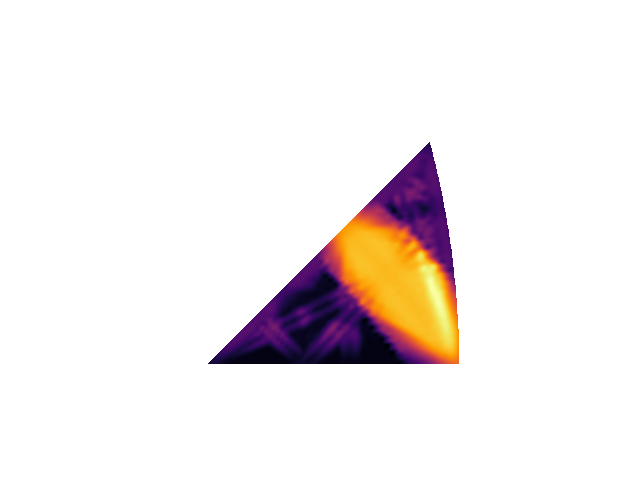

(-0.5, 999.5, -0.5, 999.5)

In [20]:
from orix.projections.stereographic_projection import StereographicProjection
from scipy.interpolate import griddata
xy = StereographicProjection.project(rot_reg_test)
z = corrs
xi = np.linspace(-0.1, 0.5, 1000)
yi = np.linspace(-0.1, 0.5, 1000)
Xi, Yi = np.meshgrid(xi, yi)
zi = griddata(xy, z, (Xi, Yi), method='cubic')

fig, ax = plt.subplots()
ax.imshow(zi, cmap="inferno")
ax.invert_yaxis()
ax.axis("off")

The correlation map in 3D

<IPython.core.display.Javascript object>


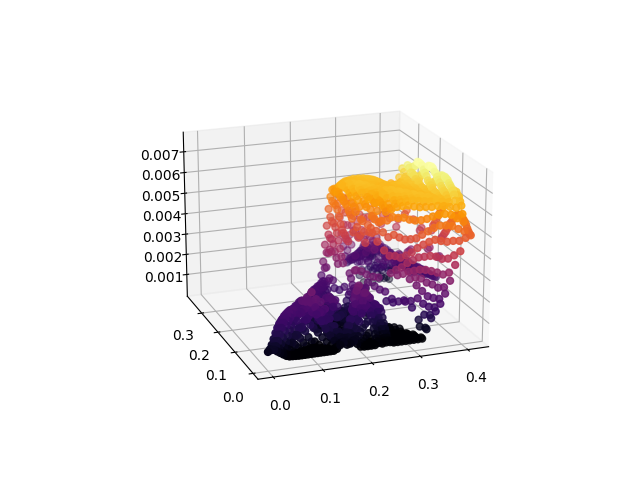

In [26]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xy[:,0], xy[:,1], z, s=25, c=z, cmap="inferno")

We can plot the best fitting pattern on top of the image to verify the result

<IPython.core.display.Javascript object>


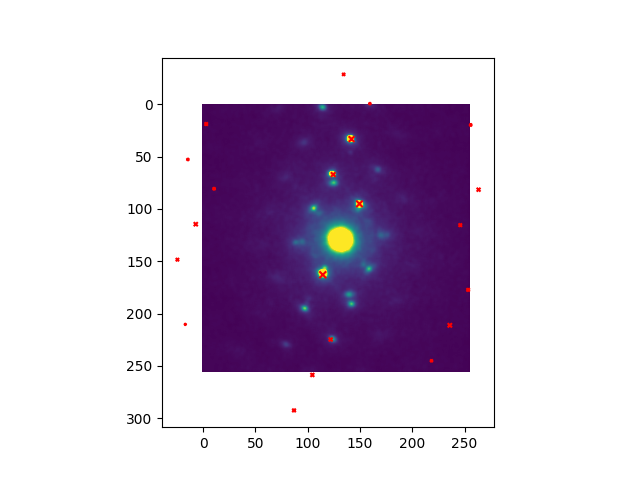

(<AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x147474250>)

In [26]:
best_match_index = np.argmax(corrs)
simulation_optimal = simulations[best_match_index]
in_plane_angle = angles[best_match_index]

plot_template_over_pattern(image_test, simulation_optimal, in_plane_angle=in_plane_angle,
                                coordinate_system = "cartesian", vmax=2000)

To index an entire dataset, the full indexation calculation is too slow but the fast method is too inaccurate. So we choose a mixed approach whereby first the fast calculation is performed, and then a number of these are chosen for a full calculation based on maximum correlation. How many templates you want to run through the entire calculation is up to you.

In [58]:
from pyxem.utils.indexation_utils import correlate_library_to_pattern_partial

p_indexes, p_angles, p_corrs, p_corrs_inv = correlate_library_to_pattern_partial(image_test,
                                                                                 simulations, keep=500)
best_fit_index_fast = p_indexes[np.argmax(p_corrs)]
print("Fast best fit index: ", best_fit_index_fast)
print("Same: ", best_fit_index_fast == best_fit_index)

1071
Same:  True


<IPython.core.display.Javascript object>


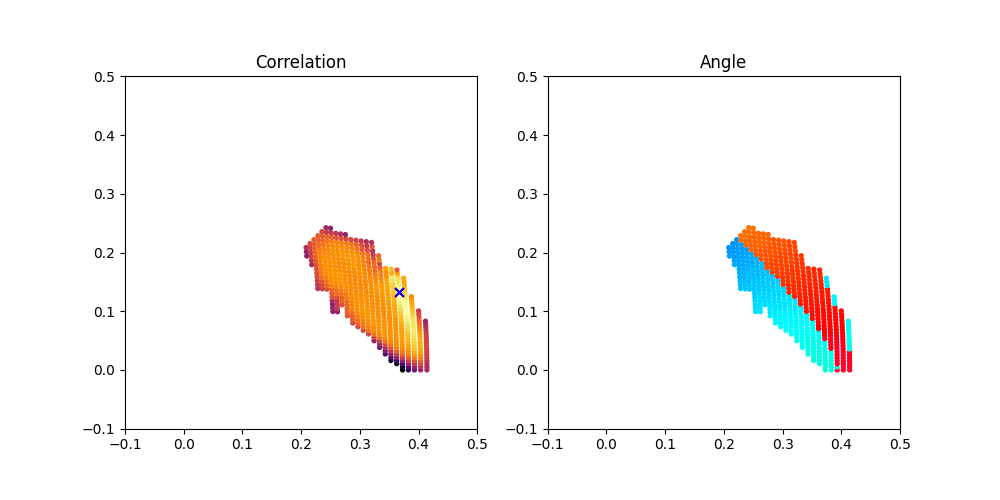

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax3 = ax.ravel()
ax1.set_title("Correlation")
ax1.scatter(rot_reg_test[p_indexes], s = 8, c = p_corrs, cmap="inferno", vmax = np.amax(p_corrs))
ax1.scatter(rot_reg_test[best_fit_index], s=40, c="red", marker="x")
ax1.scatter(rot_reg_test[best_fit_index_fast], s=40, c="blue", marker="x")
ax3.set_title("Angle")
ax3.scatter(rot_reg_test[p_indexes], s = 8, c = p_angles, cmap="hsv")
for i in [ax1, ax3]:
    i.set_xlim(-0.1, 0.5)
    i.set_ylim(-0.1, 0.5)

If you don't care about the entire correlation map, you can also just get the `n_best` matches returned. This also uses the 2-step matching approach, so it is important to check the parameter `keep`.

In [87]:
from pyxem.utils.indexation_utils import get_n_best_matches

ImportError: cannot import name 'get_n_best_matches' from 'pyxem.utils.indexation_utils' (/Users/nielscautaerts/Documents/PythonProjects/FORKS/pyxem/pyxem/utils/indexation_utils.py)

In [83]:
n_best = 5
indices, cors, angles = get_n_best_matches(image_test, simulations, n_best, keep=500)

<IPython.core.display.Javascript object>


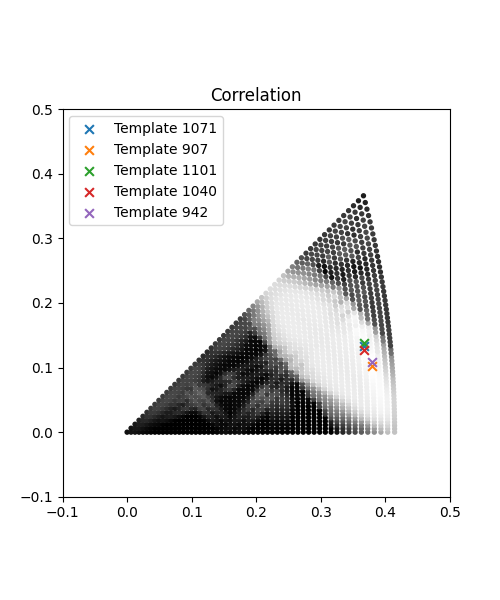

In [86]:
fig, ax1 = plt.subplots(1, figsize=(5, 6), subplot_kw={"projection": "stereographic"})
ax1.set_title("Correlation")
ax1.scatter(rot_reg_test, s = 8, c = corrs, cmap="Greys_r")

colors = [f"C{i}" for i in range(n_best)]
for i, c in zip(indices, colors):
    ax1.scatter(rot_reg_test[i], s=40, c=c, marker="x", label=f"Template {i}")

ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)
ax1.legend()

# 4. Indexing an entired 4D-STEM dataset with in-plane-rotation optimization

In [89]:
import pyxem as pxm
file_location = "Data/sample_with_g.hspy"
data_file = pxm.load(file_location, lazy=True)

In [90]:
data_file.data

,Array,Chunk
Bytes,85.20 MB,524.29 kB
Shape,"(26, 25, 256, 256)","(2, 2, 256, 256)"
Count,170 Tasks,169 Chunks
Type,uint16,numpy.ndarray


In [91]:
from pyxem.utils.indexation_utils import index_dataset_with_template_rotation

In [93]:
result = index_dataset_with_template_rotation(data_file,
                                              diff_lib,
                                              ["steel"],
                                              optimize_direct_beam=True,
                                              chunks="auto",
                                              delta_r=1,
                                              delta_theta=1,
                                              n_best=3,
                                              keep=500)

[########################################] | 100% Completed |  1min 29.1s


In [134]:
solution = result["steel"]["orientation"][:,:,0,:]
rotations_solution =  Rotation.from_euler(np.deg2rad(solution))
beamdirs_sol = rotations_solution*Vector3d.zvector()

In [135]:
# The vectors should fit into the cubic fundamental triangle (001), (101), (111), i.e. Z>=X>=Y
# this is already the case due to our choice of fundamental triangle

In [136]:
# the following column vectors should map onto R [100], G [010], B[001], i.e. the identity. So the inverse of 
# this matrix maps the beam directions onto the right color vector
color_corners = np.array([[0, 1/np.sqrt(2), 1/np.sqrt(3)],
                          [0, 0,            1/np.sqrt(3)],
                          [1, 1/np.sqrt(2), 1/np.sqrt(3)]])
color_mapper = np.linalg.inv(color_corners)

In [137]:
# a bit of wrangling
data_sol = beamdirs_sol.data
flattened = data_sol.reshape(np.product(data_sol.shape[:-1]), 3).T
rgb_mapped = np.dot(color_mapper, flattened).T
rgb_mapped = rgb_mapped.reshape(data_sol.shape)

<IPython.core.display.Javascript object>


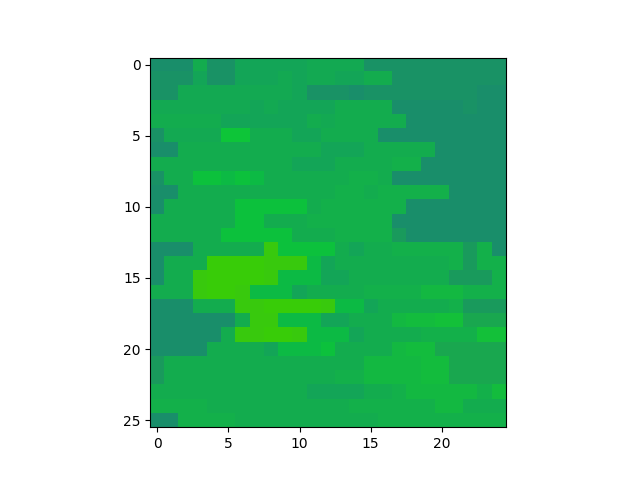

In [138]:
fig, ax = plt.subplots()
ax.imshow(rgb_mapped)

# 5. Exporting the results

In [ ]:
def result_to_array(result, phase):
    angles = result[phase]["orientation"]
    ys, xs = angles.shape[:-1]
    y = np.arange(ys)
    x = np.arange(xs)
    X, Y = np.meshgrid(x, y)
    Y = Y.ravel()
    Y = Y.reshape(Y.shape[0],-1)
    X = X.ravel().reshape(Y.shape[0],-1)
    angles = angles.reshape((ys*xs, 3))
    phase_array = np.ones(X.shape).reshape(Y.shape[0],-1)
    quality = result[phase]["correlation"].reshape(Y.shape[0],-1)
    asciform = np.hstack([X, Y, angles, phase_array, quality])
    return asciform

In [ ]:
np.savetxt("Data/steel-result.txt", result_to_array(result, "steel"), delimiter="\t", newline="\r\n")

# ^ working
-----------------------
# v highly experimental crap

## Indexing a full dataset
* first take a relevant sample

In [7]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import matplotlib.pyplot as plt

In [8]:
file_location = "/Users/nielscautaerts/Documents/Work/Projects/200630Gphase/Data/201009A17-FullData4xbin.hspy"
data_file = pxm.load(file_location, lazy=True)

In [9]:
data_file.axes_manager

<Axes manager, axes: (260, 200|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    260 |      0 |       0 |       2 |     nm 
               y |    200 |      0 |       0 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

In [10]:
daar = data_file.data.rechunk({0: "auto", 1: "auto", 2: None, 3: None})

In [11]:
daar.chunks

((39, 39, 39, 39, 39, 5),
 (26, 26, 26, 26, 26, 26, 26, 26, 26, 26),
 (256,),
 (256,))

In [12]:
image_test = daar[2, 3, :, :].compute()

In [13]:
from pyxem.utils.dask_tools import _get_dask_array

_get_dask_array(data_file)

,Array,Chunk
Bytes,6.82 GB,786.43 kB
Shape,"(200, 260, 256, 256)","(3, 2, 256, 256)"
Count,8711 Tasks,8710 Chunks
Type,uint16,numpy.ndarray


In [639]:
sample = data_file.inav[298.:348., 192.:245.]

In [641]:
sample.compute()

[########################################] | 100% Completed |  0.9s


In [643]:
sample.save("data/sample_with_g.hspy")

In [36]:
_get_dask_array(sample)

dask.array<array, shape=(26, 25, 256, 256), dtype=uint16, chunksize=(26, 25, 256, 256), chunktype=numpy.ndarray>

## Defining helper functions

In [2]:
@njit
def _circular_on_mask(X, Y, radius, center):
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center > radius
    return mask

@njit
def _multiple_circles_mask(X, Y, point_coordinates, radii):
    image_size = X.shape
    mask = (np.zeros_like(X) == 0)
    for i in range(point_coordinates.shape[0]):
        x, y = point_coordinates[i]
        circle_mask = _circular_on_mask(X, Y, radii[i], center=(x, y))
        mask = mask & circle_mask
    return mask

def _template_to_negative_mask(point_coordinates, radius, image_size, beam_center = None):
    if beam_center is None:
        beam_center = (image_size[1]//2, image_size[0]//2)
    point_coordinates_shifted = point_coordinates.copy()
    point_coordinates_shifted[:, 0] = point_coordinates_shifted[:, 0] + beam_center[0]
    point_coordinates_shifted[:, 1] = point_coordinates_shifted[:, 1] + beam_center[1]
    h, w = image_size
    x = np.arange(w)
    y = np.arange(h)
    X, Y = np.meshgrid(x, y)
    radii = np.ones(point_coordinates.shape[0])*radius
    mask = _multiple_circles_mask(X, Y, point_coordinates_shifted, radii)
    return mask

def _invert_mask(mask):
    return 1-mask

# Actual indexation

In [465]:
np.array(np.ndindex(12, 12))

array(<numpy.ndindex object at 0x17625a250>, dtype=object)

## Testing things again

In [420]:
sample = hs.load("data/sample_with_g.hspy")

In [551]:
%%time
polar_sample = _chunk_to_polar(sample.data, 1, 1, True)

CPU times: user 8.77 s, sys: 842 ms, total: 9.61 s
Wall time: 3.97 s


In [543]:
polar_sample.shape

(26, 25, 360, 182)

In [473]:
%%time
indexation = _index_chunk(polar_sample, r, theta, intensities, 0.93)

CPU times: user 1min 4s, sys: 401 ms, total: 1min 4s
Wall time: 21.3 s


In [424]:
indexation.shape

(26, 25, 3)

<IPython.core.display.Javascript object>


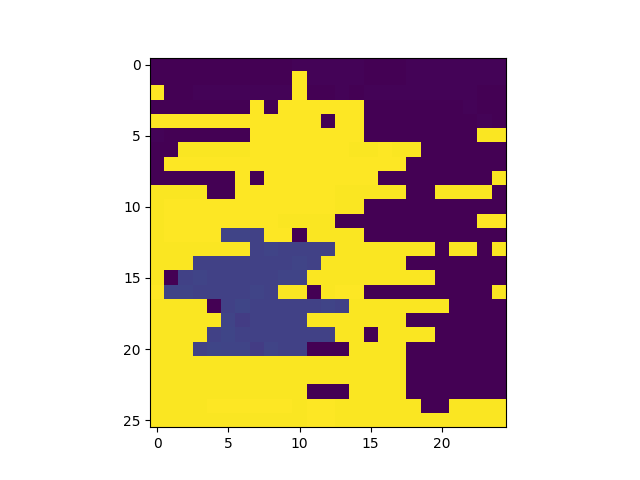

In [427]:
fig, ax = plt.subplots()
ax.imshow(indexation[:,:,2])

In [545]:
file_location = "/Users/nielscautaerts/Documents/Work/Projects/200630Gphase/Data/201009A17-FullData4xbin.hspy"
data_file = pxm.load(file_location, lazy=True)

In [546]:
lazy_data = data_file.data
lazy_data = lazy_data.rechunk({0: "auto", 1: "auto", 2: None, 3: None})
lazy_data

dask.array<rechunk-merge, shape=(200, 260, 256, 256), dtype=uint16, chunksize=(39, 26, 256, 256), chunktype=numpy.ndarray>

In [555]:
r_dim, theta_dim = _get_polar_pattern_shape(lazy_data, 1, 1)
polar_chunking = (lazy_data.chunks[0], lazy_data.chunks[1], theta_dim, r_dim)
polar_data = lazy_data.map_blocks(_chunk_to_polar,
                                  1,
                                  1,
                                  True,
                             dtype=np.float64,
                             drop_axis=data_file.axes_manager.signal_indices_in_array,
                             chunks=polar_chunking,
                             new_axis=(2, 3),
                            )
polar_data

dask.array<_chunk_to_polar, shape=(200, 260, 360, 182), dtype=float64, chunksize=(39, 26, 360, 182), chunktype=numpy.ndarray>

In [556]:
phase_library = diff_lib["steel"]
positions, intensities = _simulations_to_arrays(phase_library["simulations"], 182)
x = positions[:,0]
y = positions[:,1]
r, theta = _cartesian_positions_to_polar(x, y, delta_r = 1, delta_theta = 1)
# map the indexation to the block
indexation = polar_data.map_blocks(_index_chunk,
                      r,
                      theta,
                      intensities,
                      0.93,
                      dtype=np.float64,
                      drop_axis=data_file.axes_manager.signal_indices_in_array,
                      chunks=(polar_data.chunks[0], polar_data.chunks[1], 3),
                      new_axis=2,
                      )
indexation

dask.array<_index_chunk, shape=(200, 260, 3), dtype=float64, chunksize=(39, 26, 3), chunktype=numpy.ndarray>

In [558]:
with ProgressBar():
    res_index_2 = indexation.compute(scheduler="threads", num_workers=4)

[########################################] | 100% Completed | 30min 43.5s


In [337]:
with ProgressBar():
    res_index = indexation.compute(scheduler="threads", num_workers=4)

[########################################] | 100% Completed | 48min 41.6s


In [338]:
res_index.shape

(200, 260, 3)

In [343]:
phase_key="steel"
result = {}
result[phase_key] = {}
result[phase_key]["template_index"] = res_index[:,:,0]
oris = diff_lib[phase_key]["orientations"]
orimap = oris[res_index[:,:,0].astype(np.uint64)]
orimap[:,:,0]=res_index[:,:,2]
result[phase_key]["orientation"] = orimap
result[phase_key]["correlation"] = res_index[:, :, 1]

In [344]:
result

{'steel': {'template_index': array([[ 635.,  635.,  635., ...,  757.,  757.,  635.],
         [ 635.,  635.,  635., ...,  635.,  635.,  757.],
         [ 757.,  757.,  757., ...,  635.,  635.,  757.],
         ...,
         [ 757.,  757.,  757., ...,  591.,  591.,  676.],
         [ 757.,  757.,  757., ...,  591.,  591.,  757.],
         [ 757.,  757.,  757., ...,  503.,  503., 1259.]]),
  'orientation': array([[[359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          ...,
          [  0.        ,  42.5070586 ,  78.13084376],
          [  0.        ,  42.5070586 ,  78.13084376],
          [359.        ,  43.27970353,  80.86170816]],
  
         [[359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          ...,
          [358.        ,  43.27970353,  80.86170816],
          [358.     

In [349]:
import pickle
with open('Data/steel-result-100.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)


<IPython.core.display.Javascript object>


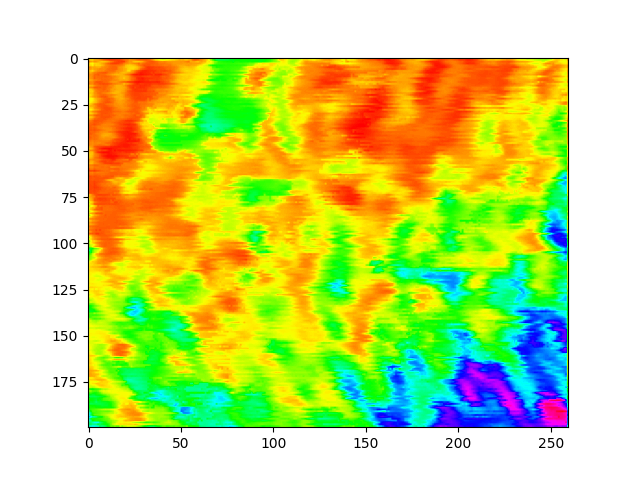

In [444]:
fig, ax = plt.subplots()
ax.imshow(res_index_2[:,:,1], cmap = "hsv")

In [364]:
result["steel"]["orientation"].reshape((200*260, 3))

array([[359.        ,  43.27970353,  80.86170816],
       [359.        ,  43.27970353,  80.86170816],
       [359.        ,  43.27970353,  80.86170816],
       ...,
       [358.        ,  43.11844878,  83.16453893],
       [358.        ,  43.11844878,  83.16453893],
       [ 15.        ,  43.11400121,  63.18333899]])

In [372]:
def result_to_array(result, phase):
    angles = result[phase]["orientation"]
    ys, xs = angles.shape[:-1]
    y = np.arange(ys)
    x = np.arange(xs)
    X, Y = np.meshgrid(x, y)
    Y = Y.ravel()
    Y = Y.reshape(Y.shape[0],-1)
    X = X.ravel().reshape(Y.shape[0],-1)
    angles = angles.reshape((ys*xs, 3))
    phase_array = np.ones(X.shape).reshape(Y.shape[0],-1)
    quality = result[phase]["correlation"].reshape(Y.shape[0],-1)
    asciform = np.hstack([X, Y, angles, phase_array, quality])
    return asciform
    

In [376]:
np.savetxt("Data/steel-result.txt", result_to_array(result, "steel"), delimiter="\t", newline="\r\n")

In [326]:
from dask.distributed import Client
client = Client()

In [327]:
index_result = index_dataset_series(data_file, diff_lib, ["steel"],
                                     chunks = "auto", keep=200)

[########################################] | 100% Completed |  1hr 25min 56.9s


KeyError: 'orientations'